# PCA-2 Over Time
18DEC2020<br>
Richard Kuzma and Iain Cruickshank


### Imports

In [1]:
import pandas as pd, numpy as np, pickle, time, re

import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') # for part of speech tagging, required for lemmatization
nltk.download('stopwords')
from nltk.corpus import stopwords

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
# import gensim.sklearn_api
import gensim.models.phrases
from gensim.parsing.porter import PorterStemmer

from urllib.parse import urlparse

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import regex as re

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/richardkuzma/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/richardkuzma/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/richardkuzma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from sklearn.decomposition import PCA, KernelPCA

import seaborn as sns
from sklearn.metrics import classification_report, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer as tf_idf
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from yellowbrick.cluster import SilhouetteVisualizer




In [3]:
with open('pca_2_dims_25k_vocab.pkl', 'rb') as f:
    df = pickle.load(f)

In [4]:
df.head()

,0,1,group,month,partisan_lean,gates,autism,implant,communism
0,-0.095521,-0.040808,4,2020-01,2,0,0,0,0
1,-0.097992,-0.113653,4,2020-01,2,0,0,0,0
2,-0.117571,-0.112891,4,2020-01,2,0,0,0,0
3,-0.113530,-0.000216,1,2020-01,2,0,0,0,0
4,-0.113890,-0.099019,4,2020-01,2,0,0,0,0


In [5]:
feat_all = df.iloc[:, :2]
labels = df.iloc[2:]

In [6]:
color_dict = {'0': 'tab:orange', 
              '1':'maroon', 
              '2':'g', 
              '3':'b', 
              '4':'tab:purple', 
              '5':'y', 
              '6': 'k'
             }

Score for number of cluster(s) 7: -50.75990050804509
Silhouette score for number of cluster(s) 7: 0.4001453371538656


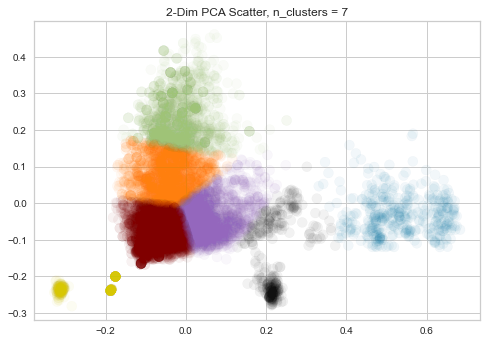

In [7]:
n_clusters = 7
km = KMeans(n_clusters=n_clusters, random_state=42).fit(feat_all)
preds = km.predict(feat_all)

print("Score for number of cluster(s) {}: {}".format(n_clusters,km.score(feat_all)))    

silhouette = silhouette_score(feat_all,preds)
print("Silhouette score for number of cluster(s) {}: {}".format(n_clusters,silhouette))

plt.scatter(feat_all[0], feat_all[1], 
                c = [color_dict[str(i)] for i in preds],
                alpha=.05,
                s = 100
               )

plt.title('2-Dim PCA Scatter, n_clusters = 7')
plt.show()

# Add cluster labels as labels

In [8]:
preds_7 = pd.DataFrame(data=preds, columns = ['preds_7'])
df = pd.concat([df, preds_7], axis = 1)
df.head()

,0,1,group,month,partisan_lean,gates,autism,implant,communism,preds_7
0,-0.095521,-0.040808,4,2020-01,2,0,0,0,0,1
1,-0.097992,-0.113653,4,2020-01,2,0,0,0,0,1
2,-0.117571,-0.112891,4,2020-01,2,0,0,0,0,1
3,-0.113530,-0.000216,1,2020-01,2,0,0,0,0,1
4,-0.113890,-0.099019,4,2020-01,2,0,0,0,0,1


# DFs by domain

In [9]:
df_dubious = df[df['group'] == 0]
df_govt = df[df['group'] == 1]
df_news = df[df['group'] == 2]
df_science = df[df['group'] == 4]

df_dubious_x_govt = df[(df['group'] == 0) | (df['group'] == 1)]
df_dubious_x_news = df[(df['group'] == 0) | (df['group'] == 2)]
df_dubious_x_science = df[(df['group'] == 0) | (df['group'] == 4)]

df_news_x_science = df[(df['group'] == 2) | (df['group'] == 4)]

In [10]:
months_ordered = ['2018-12',
                  '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',          
                  '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06','2020-07'
                   ]
months_2020 = ['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06','2020-07']


In [15]:
color_group_dict = {'0':'red',
              '1':'blue',
              '2':'tab:olive',
              '3': 'black',
              '4':'green'
             }

color_label_dict = {'0': 'tab:orange', 
                    '1':'maroon', 
                    '2':'g', 
                    '3':'b', 
                    '4':'tab:purple', 
                    '5':'y', 
                    '6': 'k'
                     }

def plot_over_time(df, title, alpha=0.05, xlim = (-.4, .7), ylim = (-.3,.5), color_dict = color_group_dict, color_by = 'group', months_range = months_2020):
    rows = len(months_range)
    cols = 1
    

    for month in months_range:
        plt.figure()
#         plt.plot(x[i],y[i])
        plt.xlim(xmin = xlim[0], xmax = xlim[1])
        plt.ylim(ymin = ylim[0], ymax = ylim[1])
            
        df_month = df[df['month'] == str(month)]
        plt.title(title + ' ' + str(month))
        plt.scatter(df_month.iloc[:, 0], df_month.iloc[:, 1], 
                c = [color_dict[str(i)] for i in df_month[color_by]],
                alpha=.05,
                s = 100
               )
        
    plt.show()
    
def plot_vs_group_over_time(df1, df2, df3, title1, title2, title3, alpha=0.05, xlim = (-.4, .7), ylim = (-.3,.5), color_dict = color_group_dict, color_by = 'group', months_range = months_2020):
#     months = sorted(df1.month.unique().tolist())
    rows = len(months_range)
    cols = 3
    
    fig, ax_array = plt.subplots(rows, cols, figsize=(14,6 * rows)) #sharey=True
    
    for i, ax_row in enumerate(ax_array):
        month = months_range[i]
        for j, axes in enumerate(ax_row):
            axes.set_xlim(xmin = xlim[0], xmax = xlim[1])
            axes.set_ylim(ymin = ylim[0], ymax = ylim[1])
            
            if j == 0:
                df1_month = df1[df1['month'] == month]
                axes.set_title(title1 + ' ' + str(month))
                axes.scatter(df1_month.iloc[:, 0], df1_month.iloc[:, 1], 
                            c = [color_dict[str(i)] for i in df1_month[color_by]],
                            alpha=alpha,
                            s = 100
                           )


            elif j == 1:
                df2_month = df2[df2['month'] == month]
                axes.set_title(title2 + ' ' + str(month))
                axes.scatter(df2_month.iloc[:, 0], df2_month.iloc[:, 1], 
                            c = [color_dict[str(i)] for i in df2_month[color_by]],
                            alpha=alpha,
                            s = 100
                           )

            
            elif j == 2: 
                df3_month = df3[df3['month'] == month]
                axes.set_title(title3 + ' ' + str(month))
                axes.scatter(df3_month.iloc[:, 0], df3_month.iloc[:, 1], 
                            c = [color_dict[str(i)] for i in df3_month[color_by]],
                            alpha=alpha,
                            s = 100
                           )

            
    plt.show()

# Plot All Domains month-by-month

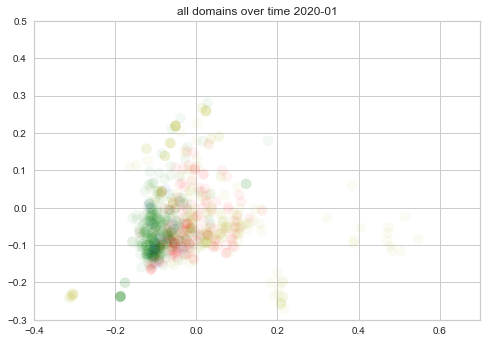

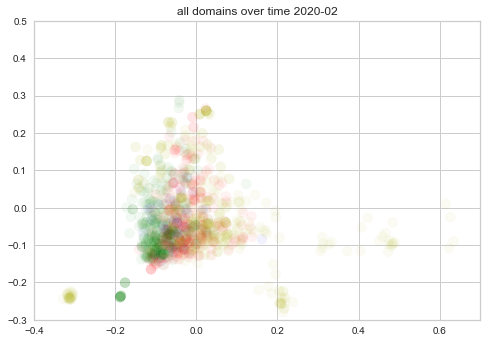

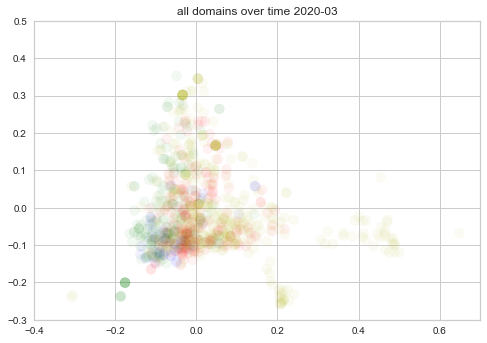

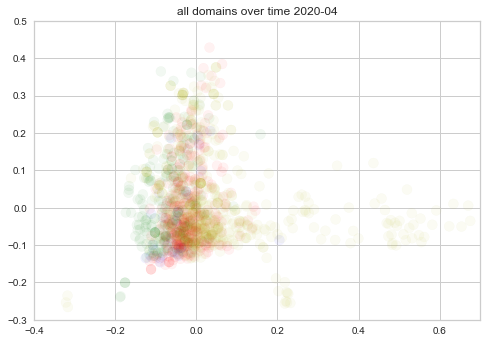

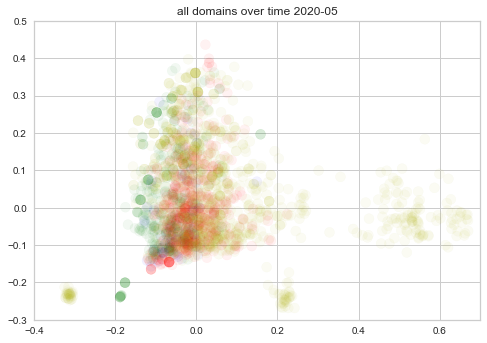

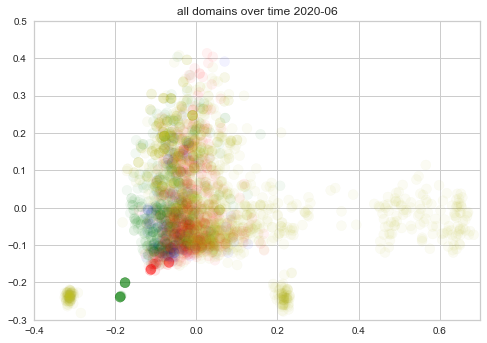

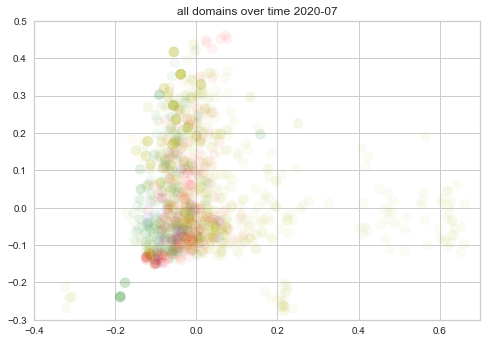

In [16]:
plot_over_time(df, 'all domains over time', 
               months_range = months_2020, 
               color_dict = color_group_dict, 
               color_by = 'group')

# Plot clusters over time

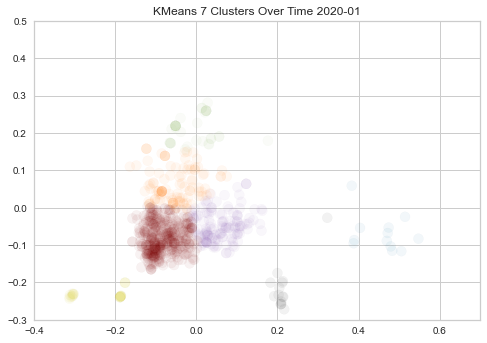

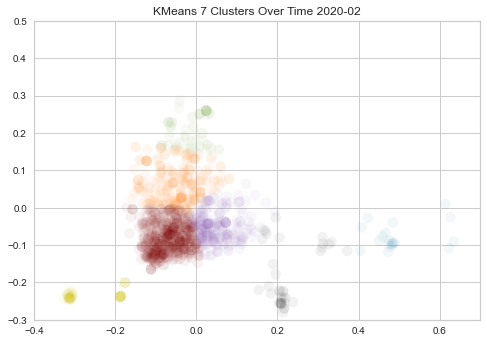

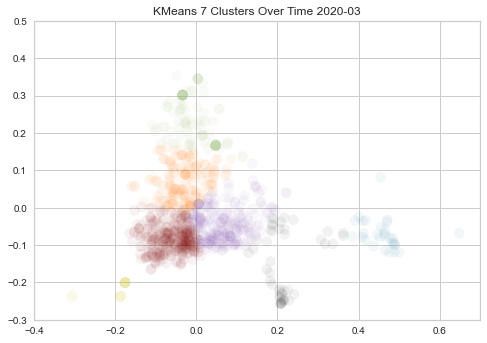

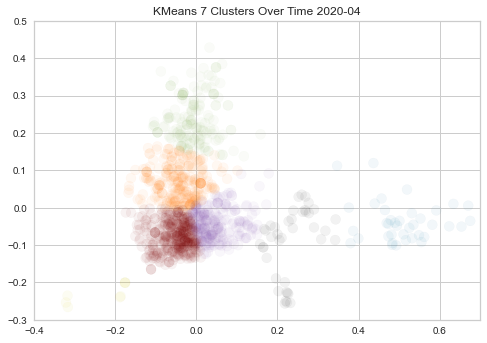

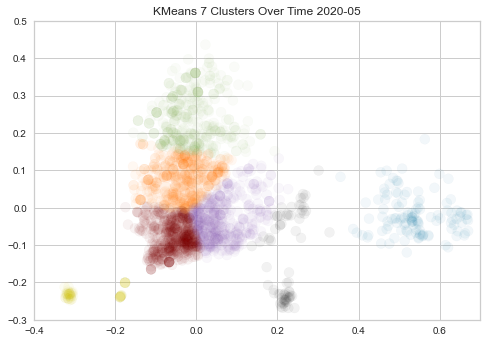

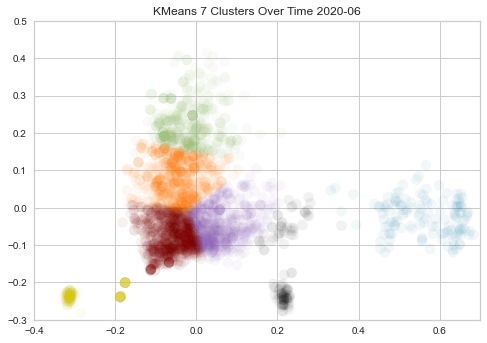

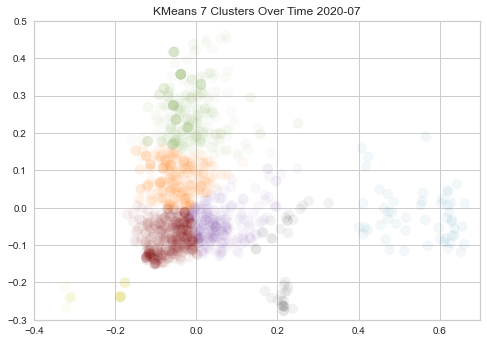

In [17]:
plot_over_time(df, 'KMeans 7 Clusters Over Time', 
               months_range = months_2020, 
               color_dict = color_label_dict, 
               color_by = 'preds_7')

# Plot one domain vs another over time

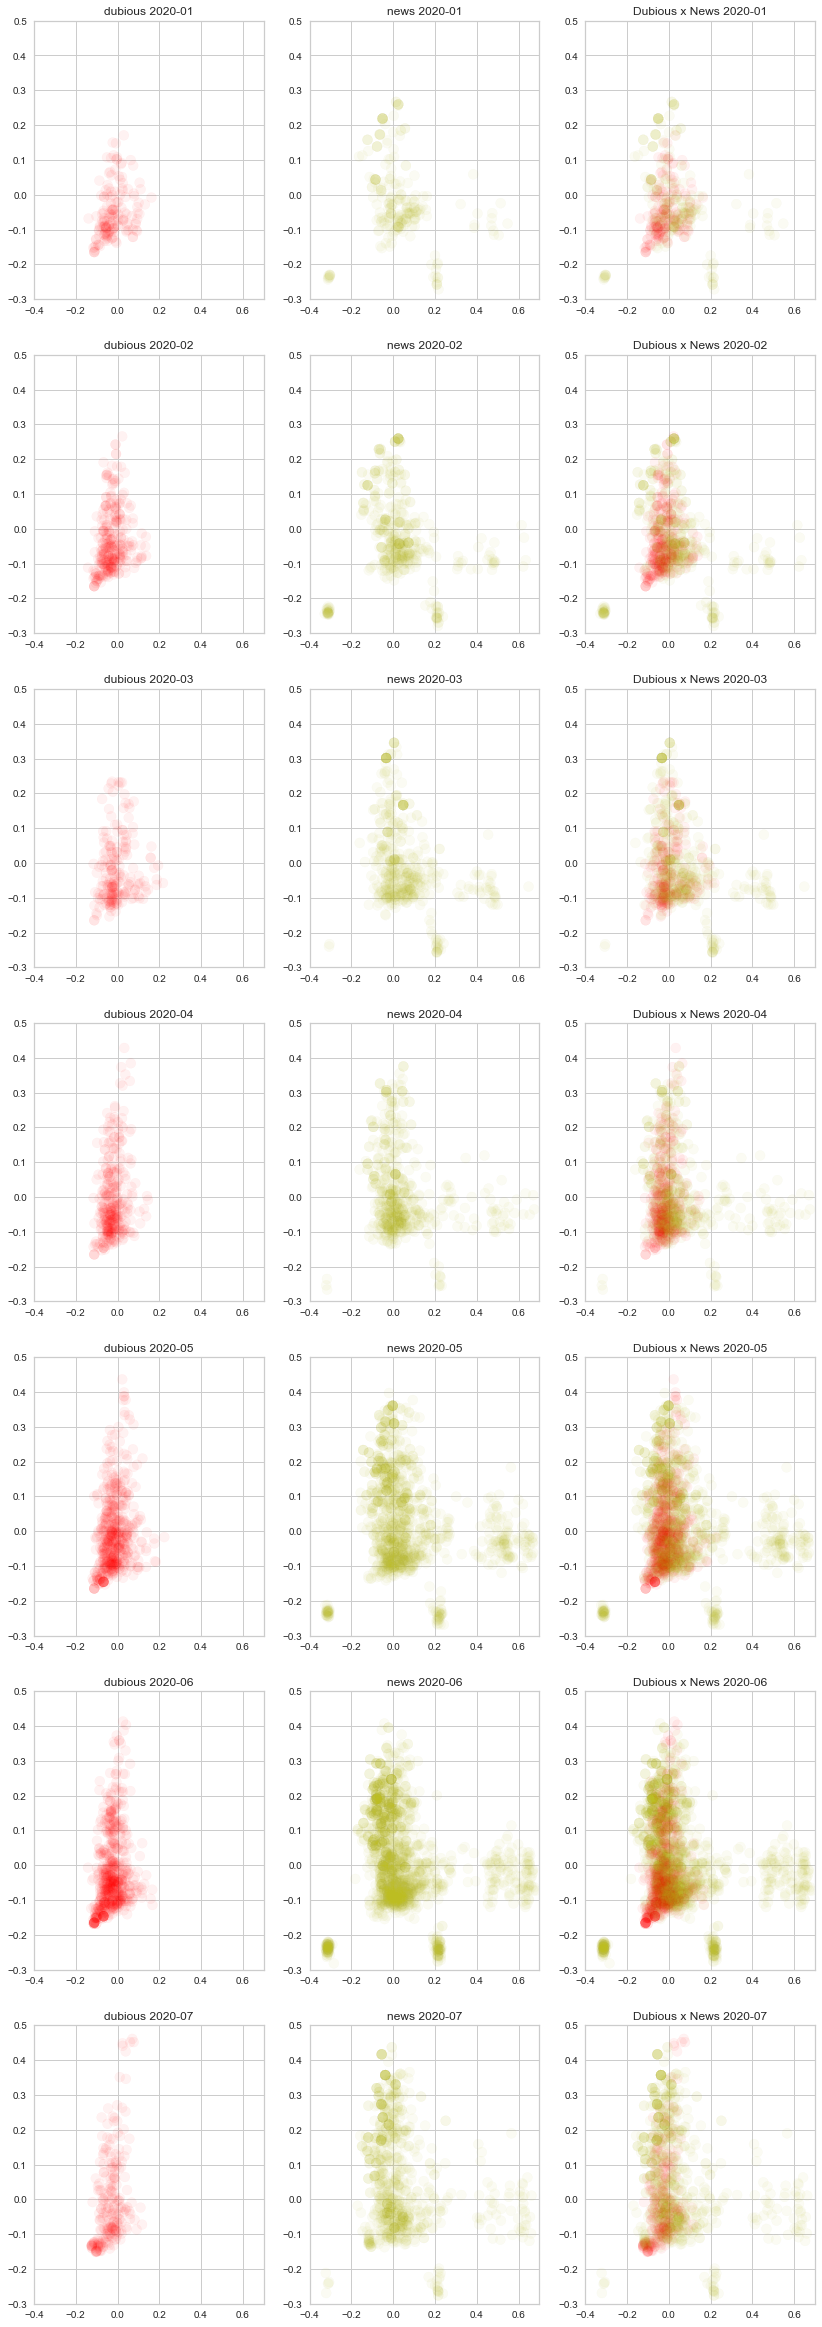

In [19]:
plot_vs_group_over_time(df_dubious, df_news, df_dubious_x_news, 
                        'dubious', 'news', 'Dubious x News',
                        color_dict = color_group_dict, color_by = 'group', months_range = months_2020)